In [8]:
import numpy as np

one_hot_v = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
h = np.dot(one_hot_v, W)

print(h)

[[ 2.18813097  0.39226017 -0.22030577]]


In [ ]:
def softmax(x):
    if x.ndim == 2:
        c = np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x - c)
        sum_exp_x = np.sum(exp_x, axis=1, keepdims=True)
        return exp_x / sum_exp_x
    else:
        c = np.max(x)
        exp_x = np.exp(x - c)
        return exp_x / np.sum(exp_x)

def CEE(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]
    
    return -np.sum(t * np.log(y + 1e-7)) / batch_size

class Softmax_with_Loss:
    def __init__(self):
        self.y = None
        self.t = None
        
    def forward(self, X, t):
        self.y = softmax(X)
        self.t = t
        loss = CEE(self.y, self.t)
        
        return loss
    
    def backward(self):
        batch_size = self.t.shape[0]
        return (self.y - self.t) / batch_size
    
#class MatMul:
#    def __init__(self, W):
#        self.params = [W]
#        self.grads = [np.zeros_like(W)]
#        self.x = None
#        
#    def forward(self, x):
#        W, = self.params
#        out = np.matmul(x, W)
#        self.x = x
#        
#        return out
#    
#    def backward(self, dout):
#        W, = self.params
#        dx = np.matmul(dout, W.T)
#        dW = np.matmul(self.x.T, dout)
#        self.grads[0][...] = dW
#        
#        return dx
    
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None
        
    def forward(self, x):
        W, = self.params
        out = np.matmul(x, W)
        self.x = x
        
        return out
    
    def backward(self, dout):
        W, = self.params
        x = self.x

        if x.ndim == 3:
            # x: (B, C, V), dout: (B, C, H)
            dx = np.matmul(dout, W.T)  # shape: (B, C, V)

            # dW = sum over all batch/context: einsum preferred
            dW = np.einsum('bci,bcj->ij', x, dout)  # (V, H)
        else:
            # x: (B, V), dout: (B, H)
            dx = np.matmul(dout, W.T)
            dW = np.matmul(x.T, dout)  # (V, H)

        self.grads[0][...] = dW
        return dx

In [107]:
layer = MatMul(W)

h = layer.forward(one_hot_v)

print(h)

[[ 2.18813097  0.39226017 -0.22030577]]


In [108]:
one_hot_v1 = np.array([[1, 0, 0, 0, 0, 0, 0]])
one_hot_v2 = np.array([[0, 0, 1, 0, 0, 0, 0]])

h = np.concatenate((one_hot_v1, one_hot_v2), axis=0)
np.sum(h, axis=0)

array([1, 0, 1, 0, 0, 0, 0])

In [109]:
one_hot_v1 = np.array([[1, 0, 0, 0, 0, 0, 0]])
one_hot_v2 = np.array([[0, 0, 1, 0, 0, 0, 0]])

input_size = 7
hidden_size = 3
output_size = 7

W_in = np.random.randn(input_size, hidden_size)
W_out = np.random.randn(hidden_size, output_size)

encoding_layer = MatMul(W_in)
decoding_layer = MatMul(W_out)

context = np.concatenate((one_hot_v1, one_hot_v2), axis=0)
context_len = len(context)
hidden_states = encoding_layer.forward(context)
hidden_state = np.sum(hidden_states, axis=0)/context_len

logit = decoding_layer.forward(hidden_state)
logit

array([-1.76573606, -0.62450752,  1.17267763,  0.76001648, -0.85724845,
       -1.51067466, -1.03860214])

In [ ]:
import numpy as np

def preprocess(text):
    text = text.lower().replace(".", " .")
    words = text.split(" ")
    
    word_to_id = {}
    id_to_word = {}
    corpus = np.array([], int)
    id = 0
    for word in words:
        if word not in word_to_id.keys():
            word_to_id[word] = id
            id_to_word[id] = word
            id += 1
        corpus = np.append(corpus, word_to_id[word])
    return corpus, word_to_id, id_to_word

def create_co_matrix(corpus, vocab_size, window_size=1):
    co_matrix = np.zeros((vocab_size, vocab_size))
    max_index = len(corpus) - 1
    for index, word_id in enumerate(corpus):
        window_left_index = index - window_size
        window_right_index = index + window_size
        
        if index < window_size:
            window_left_index = 0
        if index > max_index - window_size:
            window_right_index = max_index

        co_matrix[word_id][corpus[window_left_index:window_right_index+1]] += 1
        co_matrix[word_id][word_id] -= 1

    return co_matrix        

def create_contexts_target(corpus, window_size=1):
    corpus, word_to_id, id_to_word = preprocess(corpus)
    corpus_len = len(corpus)
    
    targets = corpus[window_size: corpus_len - window_size]
    contexts = None
    
    for index in range(window_size, corpus_len - window_size):
        print(corpus[index - window_size:index])
        print(corpus[index + 1:index + window_size+1])
        context = np.concatenate((corpus[index - window_size:index], corpus[index + 1:index + window_size+1])).reshape(1, 2*window_size)
        if contexts is None:
            contexts = context
        else:
            contexts = np.concatenate((contexts, context), axis=0)
    
    return contexts, targets

In [276]:
corpus = "You say goodbye and I say hello."

contexts, targets = create_contexts_target(corpus, window_size=1)
corpus, word_to_id, id_to_word = preprocess(corpus)
print(corpus)
print(contexts, targets)

[0]
[2]
[1]
[3]
[2]
[4]
[3]
[1]
[4]
[5]
[1]
[6]
[0 1 2 3 4 1 5 6]
[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]] [1 2 3 4 1 5]


In [159]:
def convert_one_hot(word_id_list, vocab_size):
    one_hot_vectors = []
    
    if word_id_list.ndim == 1:
        for id in word_id_list:
            one_hot_vector = [1 if i == id else 0 for i in range(vocab_size)]
            one_hot_vectors.append(one_hot_vector)
    else:
        for word_ids in word_id_list:
            one_hot_vector_list = []
            for id in word_ids:
                one_hot_vector = [1 if i == id else 0 for i in range(vocab_size)]
                one_hot_vector_list.append(one_hot_vector)
                
            one_hot_vectors.append(one_hot_vector_list)
    return np.array(one_hot_vectors)

In [160]:
targets = convert_one_hot(targets, len(word_to_id))
contexts = convert_one_hot(contexts, len(word_to_id))

In [161]:
print(targets)
print(contexts)

[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


In [261]:
from collections import OrderedDict

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        self.context_size = None
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.params = {}
        self.grads = {}
        self.layers = OrderedDict()
        
        input_size = vocab_size
        output_size = vocab_size
        self.params["W_in"] = 0.01 * np.random.randn(input_size, hidden_size).astype('f')
        self.params["W_out"] = 0.01 * np.random.randn(hidden_size, output_size).astype('f')
        
        self.layers["encoding_layer"] = MatMul(self.params["W_in"])
        self.layers["decoding_layer"] = MatMul(self.params["W_out"])
        self.last_layer = Softmax_with_Loss()

        self.word_vecs = self.params["W_in"]
        self.grads = {}
        
    def predict(self, contexts):
        _, self.context_size, _ = contexts.shape
        
        hidden_states = self.layers["encoding_layer"].forward(contexts)
        hidden_states = np.sum(hidden_states, axis=1)/self.context_size
        logits = self.layers["decoding_layer"].forward(hidden_states)
        return logits
    
    def loss(self, contexts, targets):
        logits = self.predict(contexts)
        loss = self.last_layer.forward(logits, targets)
        
        return loss
    
    def gradient(self, dout=1):
        dout = self.last_layer.backward()                                # shape: (B, V)
        dout = self.layers["decoding_layer"].backward(dout)              # shape: (B, H)
        dout = dout[:, np.newaxis, :] / self.context_size                # shape: (B, 1, H)
        dout = np.repeat(dout, self.context_size, axis=1)                # shape: (B, C, H)
        self.layers["encoding_layer"].backward(dout)                     # shape: (B, C, V)

        self.grads["W_in"] = self.layers["encoding_layer"].grads[0]
        self.grads["W_out"] = self.layers["decoding_layer"].grads[0]
        
        return self.grads
        

In [262]:
class AdaGrad:
    def __init__(self, lr):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h == None:
            self.h = {}
            for key, param in params.items():
                self.h[key] = np.zeros_like(param)
        
        for key in params.keys():
            self.h[key] = self.h[key] + grads[key]*grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

In [263]:
# 전처리
text = "You say goodbye and I say hello"
corpus, word_to_id, id_to_word = preprocess(text)
contexts_ids, targets_ids = create_contexts_target(text, window_size=1)

vocab_size = len(word_to_id)
hidden_size = 5
batch_size = 3
max_epoch = 1000
learning_rate = 0.1

contexts = convert_one_hot(contexts_ids, vocab_size)   # shape: (N, 2, V)
targets = convert_one_hot(targets_ids, vocab_size)     # shape: (N, V)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = AdaGrad(lr=learning_rate)

data_size = len(contexts)
loss_list = []

for epoch in range(max_epoch):
    batch_mask = np.random.choice(data_size, batch_size)
    batch_contexts = contexts[batch_mask]
    batch_targets = targets[batch_mask]
    
    loss = model.loss(batch_contexts, batch_targets)
    grads = model.gradient()

    optimizer.update(model.params, grads)

    loss_list.append(loss)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

print("Training complete.")


Epoch 0, Loss: 1.7917
Epoch 100, Loss: 0.3027
Epoch 200, Loss: 0.7885
Epoch 300, Loss: 0.6955
Epoch 400, Loss: 0.3114
Epoch 500, Loss: 0.2562
Epoch 600, Loss: 0.0092
Epoch 700, Loss: 0.0077
Epoch 800, Loss: 0.4670
Epoch 900, Loss: 0.0055
Training complete.


Training complete.


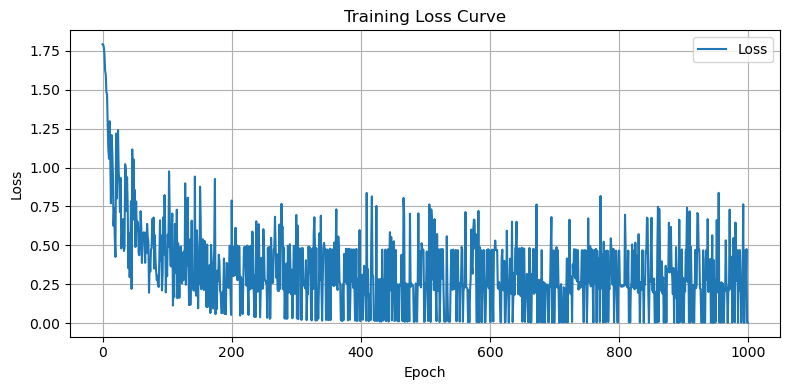

In [264]:
import matplotlib.pyplot as plt

def plot_loss_curve(loss_list):
    plt.figure(figsize=(8, 4))
    plt.plot(loss_list, label='Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
print("Training complete.")
plot_loss_curve(loss_list)



In [265]:
model.word_vecs

array([[-2.0838437 , -1.6438929 , -0.8620063 ,  2.6036682 , -0.61646867],
       [-0.8497779 ,  1.7997129 ,  1.2584901 ,  1.0277258 ,  1.2203482 ],
       [ 0.28241402, -0.16296713, -1.8797202 , -0.8944655 , -1.9171126 ],
       [-0.83703345,  1.8034978 ,  1.2560055 ,  1.0382202 ,  1.2121837 ],
       [ 0.13594787, -0.30731085, -1.8050112 , -0.76782626, -1.7911061 ],
       [-1.8164841 , -1.4163591 , -0.6499874 ,  2.4445887 , -0.57125646]],
      dtype=float32)